In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import cv2
from tqdm import tqdm
import json
import torchvision.models as models

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
class MetaDataSet(Dataset):
    def __init__(self,meta_data,root,train = True):
        super().__init__()

        with open(meta_data,'r') as f:
            meta_data = json.load(f)
        if train:
            del meta_data['fold1']
            self.data = meta_data
        else:
            self.data = {}
            self.data['fold1'] = meta_data['fold1']

        self.input_file = []
        self.root = root

        for _,val in self.data.items():
            self.input_file.extend(val['not drowsiness'])
            self.input_file.extend(val['drowsiness'])

        self.transform = transforms.Compose([
                            transforms.Resize(size = (224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])


    def __len__(self):
        return len(self.input_file)

    def __getitem__(self,index):
        video_name = self.input_file[index]
        if 'd' in video_name:
            video_path = os.path.join(os.path.join(self.root , 'drowsiness'),video_name)
        else:
            video_path = os.path.join(os.path.join(self.root , 'not drowsiness'),video_name)

        label = 0 if 'not drowsiness' in video_path else 1
        frames_list = []
        cap = cv2.VideoCapture(video_path)
        start_time = time.time()
        fps = round(cap.get(cv2.CAP_PROP_FPS))
        curr_frame = 0
        while cap.isOpened():
            ret,frame = cap.read()
            if not ret:
                break

            if curr_frame % fps == 0:
                frame = Image.fromarray(frame)
                frames_list.append(self.transform(frame))
                start_time = time.time()
            curr_frame += 1

        frames_list = torch.stack(frames_list)

        return frames_list,label

def collate_fn(batch):
    label = [d[1] for d in batch]

    batch = [torch.concatenate([d,torch.zeros(10-d.shape[0],d.shape[1],d.shape[2],d.shape[3])],dim=0)
                        if d.shape[0] < 10 else d[:10] for d,label in batch]

    return torch.stack(batch),torch.tensor(label)

NUM_WORKERS = os.cpu_count()

metadata_path = '/kaggle/input/sust-ddd-metadata/dataset_metadata.json'
root_path = '/kaggle/input/sust-ddd/SUST Driver Drowsiness Dataset'

train_data = MetaDataSet(metadata_path,root_path,train = True)
test_data = MetaDataSet(metadata_path,root_path, train = False)

train_loader = DataLoader(train_data,batch_size = 16,shuffle = True,num_workers=NUM_WORKERS,collate_fn = collate_fn)
test_loader = DataLoader(test_data,batch_size = 16,shuffle = True,num_workers=NUM_WORKERS,collate_fn = collate_fn)

In [ ]:
class LastLayer(nn.Module):
    def __init__(self,in_feature,hidden_feature,output_feature,num_layers):
        super(LastLayer, self).__init__()
        self.ln1 = nn.Linear(in_feature,hidden_feature)
        self.bn = nn.BatchNorm1d(hidden_feature)
        self.ln2 = nn.ModuleList([nn.Linear(hidden_feature,hidden_feature) for _ in range(num_layers)])
        self.bn2 = nn.ModuleList([nn.BatchNorm1d(hidden_feature) for _ in range(num_layers)])

        self.ln3 = nn.Linear(hidden_feature,output_feature)


    def forward(self, x):

        x = F.relu(self.bn(self.ln1(x)))
        for ln,bn in zip(self.ln2,self.bn2):
             x = F.relu(bn(ln(x)))
        return self.ln3(x)

class MyBaseLine(nn.Module):
    def __init__(self,effnet_hidden,effnet_out,lstm_out,n_lstm_layers,freeze = True):
        super().__init__()
        self.effnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        self.effnet.classifier.fc = LastLayer(1280,effnet_hidden,effnet_out,1)
        if freeze:
            for name,param in self.effnet.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False
        self.lstm = nn.LSTM(effnet_out,lstm_out,n_lstm_layers,batch_first = True)
        self.last_layer = nn.Linear(lstm_out,1)
        self.lstm_out = lstm_out
        self.n_lstm_layers = n_lstm_layers
        self.sigmoid = nn.Sigmoid()

    def forward(self,batch):
        """
        batch : [Batch_size,num_frames,512]
        """
        b,n,c,h,w = batch.size()
        batch_ = batch.reshape(-1,c,h,w)
        frame_embedded = self.effnet(batch_).reshape(b,n,-1)

        h0 = torch.randn(self.n_lstm_layers,b,self.lstm_out).to('cuda')
        c0 = torch.randn(self.n_lstm_layers,b,self.lstm_out).to('cuda')

        output,_ = self.lstm(frame_embedded ,(h0,c0))
        return self.sigmoid(self.last_layer(output[:,-1,:]))

In [ ]:
from torch.optim import lr_scheduler

# initializing hyperparameters and model
model = MyBaseLine(256,128,64,2).to('cuda')
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
step_size = 1
gamma = 0.8
scheduler = lr_scheduler.ExponentialLR(optimizer,gamma=gamma)
criterion = nn.BCELoss()
num_epochs = 5
threshhold = 0.5

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.7MB/s]


In [ ]:
# training loop
for epoch in range(num_epochs):
    correct = 0
    losses = 0
    for batch_idx,(data, label) in enumerate(train_loader):


        data = data.to('cuda');label = label.to('cuda')
        output = model(data)
        output = output.squeeze()
        loss = criterion(output,label.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predict = torch.where(output < threshhold , 0 ,1)
        correct += torch.sum(predict == label)
        losses += loss

        if batch_idx % 20 == 0:
            print(f'Epoch:{epoch} Iteration {batch_idx} Batch_loss {loss} Correct {correct.detach().cpu().numpy()}/{(batch_idx+1)*16}')

    print(f'Epoch {epoch} Loss:{losses / len(train_loader)} Acc :{correct/len(train_data)} Lr {optimizer.param_groups[0]["lr"]}')

    scheduler.step()

Epoch:0 Iteration 0 Batch_loss 0.9384225010871887 Correct 6/16
Epoch:0 Iteration 20 Batch_loss 0.7328321933746338 Correct 211/336
Epoch:0 Iteration 40 Batch_loss 0.7535889148712158 Correct 437/656
Epoch:0 Iteration 60 Batch_loss 0.6801105737686157 Correct 682/976
Epoch:0 Iteration 80 Batch_loss 0.6341782212257385 Correct 916/1296
Epoch 0 Loss:0.599799633026123 Acc :0.7116689682006836 Lr 0.01
Epoch:1 Iteration 0 Batch_loss 0.599800705909729 Correct 11/16
Epoch:1 Iteration 20 Batch_loss 0.5166108012199402 Correct 256/336
Epoch:1 Iteration 40 Batch_loss 0.5287588834762573 Correct 498/656
Epoch:1 Iteration 60 Batch_loss 0.42719829082489014 Correct 747/976
Epoch:1 Iteration 80 Batch_loss 0.5140278339385986 Correct 998/1296
Epoch 1 Loss:0.5410188436508179 Acc :0.7571234703063965 Lr 0.008
Epoch:2 Iteration 0 Batch_loss 0.44320017099380493 Correct 13/16
Epoch:2 Iteration 20 Batch_loss 0.43747425079345703 Correct 256/336
Epoch:2 Iteration 40 Batch_loss 0.6022679805755615 Correct 509/656
Epoch:2

In [ ]:
def check_accuracy(test_loader, model):
    num_samples = 0
    num_corrects = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to('cuda')
            targets = targets.to('cuda')

            outputs = model(data).squeeze()

            predictions = torch.where(outputs < threshhold , 0 ,1)

            num_corrects  += (predictions==targets).sum()
            num_samples += predictions.size(0)
            if batch_idx % 20 == 0:
                print(f"Test Iteration {batch_idx} Acc {num_corrects/num_samples * 100 :.2f}")
    # accuracy
    return num_corrects/num_samples

accuracy_score = check_accuracy(test_loader, model)
print(f'Accuracy score: {accuracy_score.item()}')

Test Iteration 0 Acc 50.00
Test Iteration 20 Acc 54.76
Accuracy score: 0.550000011920929


In [ ]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
savedir = '/kaggle/working/weights'
create_dir(savedir)

PATH = 'weights/model_weights_no_dropout.pth'
torch.save(model.state_dict(), PATH)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


<All keys matched successfully>

In [ ]:
def y_true_y_pred(test_loader, model, threshold=0.5):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to('cuda')
            targets = targets.to('cuda')

            outputs = model(data).squeeze()

            predictions = torch.where(outputs < threshold , 0 ,1)

            y_true.extend(targets.detach().cpu().numpy())
            y_pred.extend(predictions.detach().cpu().numpy())


    return y_true, y_pred

In [ ]:
# load
PATH = '/kaggle/input/weights/model_weights_no_dropout.pth'
model = MyBaseLine(256,128,64,2).to('cuda')
model.load_state_dict(torch.load(PATH))

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


<All keys matched successfully>

In [ ]:
import time

start = time.time()
y_true, y_pred = y_true_y_pred(test_loader, model)
end = time.time()

print(f'Time elapsed: {end-start}')

Time elapsed: 708.1622111797333


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.79      0.65       317
           1       0.56      0.30      0.39       283

    accuracy                           0.56       600
   macro avg       0.56      0.54      0.52       600
weighted avg       0.56      0.56      0.53       600



In [ ]:
accuracy_score(y_true, y_pred)

0.5583333333333333

In [ ]:
confusion_matrix(y_true, y_pred)

array([[250,  67],
       [198,  85]])

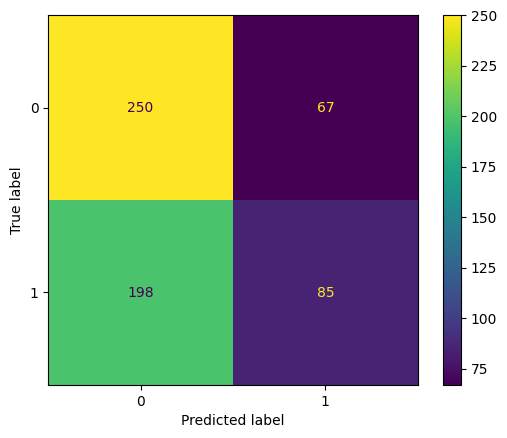

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cf = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()

plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
precision, recall, f1, _  = precision_recall_fscore_support(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Precision: [0.55555556 0.55333333]
Recall: [0.78864353 0.29328622]
F1 score: [0.65189048 0.38337182]
